# PyTorchを使う
PyTorchは深層学習フレームワークの1つ。1からプログラムをするのに比べ簡単で、かつGPUを利用した計算ができる。ほかにもTensorFlow, Chainerなど多くのフレームワークがある。本格的なディープラーニングでは、事実上、このいずれかを利用することになる。

使うときには以下のようにする。

In [1]:
import torch

## 多クラスロジスティック回帰

PyTorchでは、変数は Tensor という型に入れる。numpyのデータからはfrom_numpy関数で変換できる。

In [2]:
import numpy as np
from sklearn import datasets

iris = datasets.load_iris()
M = iris.target_names.size # クラス(アヤメの種類)の数
D = iris.data.shape[1] # 特徴量の数
X = torch.from_numpy(iris.data).float()
C = torch.from_numpy(iris.target)

In [3]:
X_train = X[0::2] # 偶数番目
X_test = X[1::2] # 奇数番目
C_train = C[0::2]
C_test = C[1::2]

多クラスロジスティック回帰は、
<span id="multiclasslogistic">
\begin{align*}
z_m&=\boldsymbol{w_m}^\top\boldsymbol{x} \\
y_m&=\text{softmax}(z_m)=\frac{\exp(z_m)}{\sum_j \exp(z_j)}
\end{align*}
</span>
だった。まず $\boldsymbol{x}$ を $\boldsymbol{W}$ で線形変換して $\boldsymbol{z}$ を得る。次に $\boldsymbol{z}$ を softmax 関数に通して $\boldsymbol{y}$ を得るという手順であった。

PyTorchでは、このようなベクトル(テンソル)の変換の繰り返しでモデルを定義する。線形変換には Linear, 対数 softmax には LogSoftmax というモジュールをモデルに順番に追加する。

In [5]:
model = torch.nn.Sequential()
model.add_module("linear", torch.nn.Linear(in_features=D,out_features=M))
model.add_module("softmax", torch.nn.LogSoftmax(dim=1))

損失関数は、自分で定義しなくとも最初からいろいろ用意されている。ロジスティック回帰の損失関数は負の対数尤度 (Negative Log Likelihood) なので NLLLoss という関数が使える。

In [12]:
crossEntropyLoss = torch.nn.NLLLoss() # 損失関数

PyTorchを使ったモデル学習の基本は次の通りである。

まず、forward (前向き) 計算を行う。入力から出力への向きのことを前向きと呼ぶ。ここでは $\boldsymbol{x}$ から $\boldsymbol{z}$ 、$\boldsymbol{z}$ から $\boldsymbol{y}$ の計算である。上で定義した model 関数を使うと、出力の計算(=forward計算)が行える。

出力がわかると、教師データとの関係から損失が計算できる。次に損失を計算する。上で定義した crossEntropyLoss 関数に、出力と教師データを与えると計算してくれる。

次に、最小化したい値(ここでは loss)に対してbackward (後向き) 計算を行う。ここで計算されているのは誤差と呼ばれる値である。多クラスロジスティック回帰の場合には、クラス $m$ の教師信号との誤差は $y_m-t_m$ である。第2回の課題(2)でやったように、 $E$ の勾配は
$\sum_k (y_{km}-t_{km})\boldsymbol{x}$ となる。つまり、誤差と入力の積によって勾配が計算できる。PyTorch の backward 関数は、各層の誤差を計算するのと同時に、その層への入力との積から勾配 grad を計算し、パラメータの中に保存する。なお計算した勾配は蓄積される仕様なので、backward計算の前にゼロクリアしている。

後は今までと同じように、勾配に学習係数をかけた値をパラメータから引けば1回の更新が終了する。

In [7]:
learning_rate = 0.1
step_num = 10000

for i in range(step_num):
    Y = model(X_train) # forward計算
    loss = crossEntropyLoss(Y, C_train) # 損失の計算
    W, b = model.parameters()
    if W.grad is not None:
        W.grad.data.zero_()
        b.grad.data.zero_()

    loss.backward() # backward計算
    # 勾配法
    W.data -= learning_rate * W.grad.data
    b.data -= learning_rate * b.grad.data

学習の済んだモデルにテストデータの入力を入れると各クラスの対数確率が得られる。対数確率が最大のクラスが認識結果となる。

In [8]:
Y_test = model(X_test)
result = np.array([np.argmax(y) for y in Y_test.detach().numpy()])
answer = C_test.detach().numpy()
np.sum(np.equal(result, answer)) / C_test.shape[0]

0.9466666666666667

# 手書き数字の認識

アヤメの分類よりももう少しだけ本格的な問題を解いてみる。[MNIST](https://en.wikipedia.org/wiki/MNIST_database)は0から9までの手書き数字画像のデータベースである。これを使って、多クラスロジスティック回帰モデルで手書き数字の認識をやってみよう。

In [4]:
from shutil import copyfileobj
from six.moves import urllib
from sklearn.datasets import fetch_mldata
import os
import urllib.request

# プロキシ設定 (大学の中でやるときだけ)
proxy = urllib.request.ProxyHandler({'http': 'http://proxya.cc.utsunomiya-u.ac.jp:8080',
                                     'https': 'http://proxya.cc.utsunomiya-u.ac.jp:8080'})
opener = urllib.request.build_opener(proxy)
urllib.request.install_opener(opener)
# プロキシ設定 ここまで

if not os.path.exists("mldata"):
    os.makedirs("mldata")
mnist_save_path = os.path.join("mldata","mnist-original.mat")
if not os.path.exists(mnist_save_path):
    mnist_url = urllib.request.urlopen("http://github.com/amplab/datascience-sp14/raw/master/lab7/mldata/mnist-original.mat")
    with open(mnist_save_path, "wb") as matlab_file:
        copyfileobj(mnist_url, matlab_file)

mnist = fetch_mldata("MNIST original",data_home=".")

mnist.data には0から255までの画素値、 mnist.target にはどの数字かを表す数値が入っている。まずXを最大値1に正規化する。

In [5]:
X = mnist.data / 255.0
C = mnist.target.astype(np.long)
X.shape

(70000, 784)

データ数は全部で70000個、特徴量の数は画素数($28\times28=784$)である。

以下のコードで、データの1つを描画できる。Xの添字を適当に変えて、MNISTがどのようなデータなのか眺めておこう。

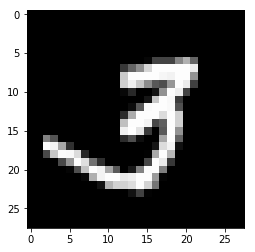

In [6]:
%matplotlib inline
import matplotlib.pyplot as plt

plt.imshow(X[23450].reshape(28,28), cmap='gray')

In [7]:
M = 10 # 数字の数
D = 28 * 28 # 特徴量の数

90%のデータで訓練、残り10%でテストする。

In [8]:
from sklearn.model_selection import train_test_split
X_train, X_test, C_train, C_test = train_test_split(X, C, test_size=0.1, random_state=0)

モデル定義はirisの時と同じ。

In [14]:
model = torch.nn.Sequential()
model.add_module("linear", torch.nn.Linear(in_features=D,out_features=M))
model.add_module("softmax", torch.nn.LogSoftmax(dim=1))

学習部分については関数化しておこう。

In [11]:
def train(model, X, C, learning_rate=0.5, step_num=100):
    for i in range(step_num):
        Y = model(X) # forward計算
        loss = crossEntropyLoss(Y, C) # 損失の計算
        W, b = model.parameters()
        if W.grad is not None:
            W.grad.data.zero_()
            b.grad.data.zero_()

        loss.backward() # backward計算
        # 勾配法
        W.data -= learning_rate * W.grad.data
        b.data -= learning_rate * b.grad.data
        print("epoch {}: loss = {}".format(i+1,loss))

では学習してみよう。

In [16]:
train(model, torch.from_numpy(X_train).float(),torch.from_numpy(C_train),step_num=200)

epoch 1: loss = 2.3183979988098145
epoch 2: loss = 1.8407660722732544
epoch 3: loss = 1.5262320041656494
epoch 4: loss = 1.3103580474853516
epoch 5: loss = 1.1680082082748413
epoch 6: loss = 1.0559115409851074
epoch 7: loss = 0.9797663688659668
epoch 8: loss = 0.9114518761634827
epoch 9: loss = 0.8633440136909485
epoch 10: loss = 0.8175839781761169
epoch 11: loss = 0.783067524433136
epoch 12: loss = 0.7512417435646057
epoch 13: loss = 0.7253132462501526
epoch 14: loss = 0.702219545841217
epoch 15: loss = 0.6823620200157166
epoch 16: loss = 0.6647487878799438
epoch 17: loss = 0.6491159796714783
epoch 18: loss = 0.6350514888763428
epoch 19: loss = 0.6223106384277344
epoch 20: loss = 0.6106955409049988
epoch 21: loss = 0.6000427603721619
epoch 22: loss = 0.590219259262085
epoch 23: loss = 0.5811310410499573
epoch 24: loss = 0.5726924538612366
epoch 25: loss = 0.5648188591003418
epoch 26: loss = 0.5574703216552734
epoch 27: loss = 0.5505785346031189
epoch 28: loss = 0.5441033244132996
epoc

正解率を調べる。

In [17]:
Y_test = model(torch.from_numpy(X_test).float())
result = np.array([np.argmax(y) for y in Y_test.detach().numpy()])
answer = C_test
np.sum(np.equal(result, answer)) / C_test.shape[0]

0.9044285714285715

精度はだいたい90%くらいになったことだろう。

ネット上で同じデータ、同じロジスティック回帰を使ってテストした例では、92,3%くらいの精度になっているようだ。90%は少しだけ劣っているが、1つには学習方法もある。ここでは全データで一挙に重みを更新するバッチ学習というのを行っているが、これをいくつかのミニバッチに分割して勾配降下法を実行するSGD(確率的勾配降下法)がポピュラーな学習アルゴリズムで、局所最小値にはまる危険が少ない特長を持っている。

## Feed-forwardネットワーク
多クラスロジスティック回帰を少し拡張してみる。(記号を少し変えてある)
\begin{align*}
\boldsymbol{a}_1&={\boldsymbol{W}^{(1)}}^\top\boldsymbol{x} \\
\boldsymbol{z}_1&=\sigma(\boldsymbol{a}_1) \\
\boldsymbol{a}_2&={\boldsymbol{W}^{(2)}}^\top\boldsymbol{z}_1^+ \\
\boldsymbol{y}&=\text{softmax}(\boldsymbol{a}_2)
\end{align*}
$\boldsymbol{x}$ → $\boldsymbol{z_1}$ → $\boldsymbol{y}$ の順でデータが変換されているのがわかるだろうか。

$\boldsymbol{W}^{(1)}$ は $(D+1)\times H$行列、 $\boldsymbol{W}^{(2)}$ は $(H+1)\times M$行列である。(プラス1は切片のため)  $\boldsymbol{z}^+$ は $\boldsymbol{z}$ を1で拡張したベクトルを表す。$H$ は任意に決められるが、この数が重要であることが後でわかる。

$\sigma(\cdot)$ はロジスティック関数であり、上式の $\boldsymbol{z}_1=\sigma(\boldsymbol{a}_1)$ とは $\boldsymbol{a}_1$ の各次元の値をロジスティック関数に通した値をつなげてベクトルにするという意味である。この関数は、PyTorchでは torch.nn.Sigmoid() として提供されている。

In [9]:
def train(model, X, C, learning_rate=0.5, step_num=100):
    for i in range(step_num):
        Y = model(X) # forward計算
        loss = crossEntropyLoss(Y, C) # 損失の計算
        W1, b1, W2, b2 = model.parameters()
        if W1.grad is not None:
            W1.grad.data.zero_()
            b1.grad.data.zero_()
        if W2.grad is not None:
            W2.grad.data.zero_()
            b2.grad.data.zero_()
        loss.backward() # backward計算
        # 勾配法
        W1.data -= learning_rate * W1.grad.data
        b1.data -= learning_rate * b1.grad.data
        W2.data -= learning_rate * W2.grad.data
        b2.data -= learning_rate * b2.grad.data

        print("epoch {}: loss = {}".format(i+1,loss))

In [138]:
hidden_units = 500
model = torch.nn.Sequential()
model.add_module("linear1", torch.nn.Linear(in_features=D,out_features=hidden_units))
model.add_module("softmax1", torch.nn.LogSoftmax(dim=1))
model.add_module("linear2", torch.nn.Linear(in_features=hidden_units,out_features=M))
model.add_module("softmax2", torch.nn.LogSoftmax(dim=1))

In [139]:
from torch.utils.data import Dataset, DataLoader

class MNISTTrainDataSet(Dataset):
    def __len__(self):
        return X_train.shape[0]
    
    def __getitem__(self, idx):
        return X_train[idx].astype('float'), C_train[idx]

In [140]:
batch_size = 50       # The size of input data took for one iteration

mnist = MNISTTrainDataSet()
train_loader = DataLoader(dataset=mnist,batch_size=batch_size,shuffle=True)

In [141]:
num_epochs = 800        # The number of times entire dataset is trained
learning_rate = 0.0005  # The speed of convergence

for epoch in range(num_epochs):
    for i, (X, C) in enumerate(train_loader):   # Load a batch of images with its (index, data, class)
        X = X.float()
        Y = model(X) # forward計算
        loss = crossEntropyLoss(Y, C) # 損失の計算
        W1, b1, W2, b2 = model.parameters()
        if W1.grad is not None:
            W1.grad.data.zero_()
            b1.grad.data.zero_()
        if W2.grad is not None:
            W2.grad.data.zero_()
            b2.grad.data.zero_()
        loss.backward() # backward計算
        # 勾配法
        W1.data -= learning_rate * W1.grad.data
        b1.data -= learning_rate * b1.grad.data
        W2.data -= learning_rate * W2.grad.data
        b2.data -= learning_rate * b2.grad.data
    Y = model(torch.from_numpy(X_train).float())
    C = torch.from_numpy(C_train)
    print('Epoch [%d/%d], Loss: %.4f' % (epoch+1, num_epochs, crossEntropyLoss(Y, C)))

Epoch [1/800], Loss: 1.9720
Epoch [2/800], Loss: 1.7232
Epoch [3/800], Loss: 1.4091
Epoch [4/800], Loss: 1.2122
Epoch [5/800], Loss: 1.0147
Epoch [6/800], Loss: 0.9130
Epoch [7/800], Loss: 0.8088
Epoch [8/800], Loss: 0.7699
Epoch [9/800], Loss: 0.7385
Epoch [10/800], Loss: 0.6644
Epoch [11/800], Loss: 0.6145
Epoch [12/800], Loss: 0.5879
Epoch [13/800], Loss: 0.5738
Epoch [14/800], Loss: 0.5400
Epoch [15/800], Loss: 0.5469
Epoch [16/800], Loss: 0.5176
Epoch [17/800], Loss: 0.4927
Epoch [18/800], Loss: 0.4867
Epoch [19/800], Loss: 0.4703
Epoch [20/800], Loss: 0.4750
Epoch [21/800], Loss: 0.4601
Epoch [22/800], Loss: 0.4499
Epoch [23/800], Loss: 0.4393
Epoch [24/800], Loss: 0.4357
Epoch [25/800], Loss: 0.4332
Epoch [26/800], Loss: 0.4225
Epoch [27/800], Loss: 0.4230
Epoch [28/800], Loss: 0.4144
Epoch [29/800], Loss: 0.4066
Epoch [30/800], Loss: 0.4016
Epoch [31/800], Loss: 0.4113
Epoch [32/800], Loss: 0.4065
Epoch [33/800], Loss: 0.3898
Epoch [34/800], Loss: 0.3847
Epoch [35/800], Loss: 0

Epoch [278/800], Loss: 0.2796
Epoch [279/800], Loss: 0.2773
Epoch [280/800], Loss: 0.2793
Epoch [281/800], Loss: 0.2759
Epoch [282/800], Loss: 0.2788
Epoch [283/800], Loss: 0.2812
Epoch [284/800], Loss: 0.2806
Epoch [285/800], Loss: 0.2759
Epoch [286/800], Loss: 0.2821
Epoch [287/800], Loss: 0.2793
Epoch [288/800], Loss: 0.2779
Epoch [289/800], Loss: 0.2788
Epoch [290/800], Loss: 0.2771
Epoch [291/800], Loss: 0.2809
Epoch [292/800], Loss: 0.2786
Epoch [293/800], Loss: 0.2811
Epoch [294/800], Loss: 0.2791
Epoch [295/800], Loss: 0.2776
Epoch [296/800], Loss: 0.2798
Epoch [297/800], Loss: 0.2755
Epoch [298/800], Loss: 0.2739
Epoch [299/800], Loss: 0.2758
Epoch [300/800], Loss: 0.2745
Epoch [301/800], Loss: 0.2758
Epoch [302/800], Loss: 0.2825
Epoch [303/800], Loss: 0.2754
Epoch [304/800], Loss: 0.2765
Epoch [305/800], Loss: 0.2755
Epoch [306/800], Loss: 0.2775
Epoch [307/800], Loss: 0.2767
Epoch [308/800], Loss: 0.2737
Epoch [309/800], Loss: 0.2790
Epoch [310/800], Loss: 0.2756
Epoch [311

Epoch [552/800], Loss: 0.2634
Epoch [553/800], Loss: 0.2639
Epoch [554/800], Loss: 0.2607
Epoch [555/800], Loss: 0.2602
Epoch [556/800], Loss: 0.2617
Epoch [557/800], Loss: 0.2615
Epoch [558/800], Loss: 0.2648
Epoch [559/800], Loss: 0.2628
Epoch [560/800], Loss: 0.2607
Epoch [561/800], Loss: 0.2625
Epoch [562/800], Loss: 0.2666
Epoch [563/800], Loss: 0.2586
Epoch [564/800], Loss: 0.2605
Epoch [565/800], Loss: 0.2609
Epoch [566/800], Loss: 0.2629
Epoch [567/800], Loss: 0.2652
Epoch [568/800], Loss: 0.2650
Epoch [569/800], Loss: 0.2645
Epoch [570/800], Loss: 0.2618
Epoch [571/800], Loss: 0.2686
Epoch [572/800], Loss: 0.2627
Epoch [573/800], Loss: 0.2599
Epoch [574/800], Loss: 0.2646
Epoch [575/800], Loss: 0.2574
Epoch [576/800], Loss: 0.2613
Epoch [577/800], Loss: 0.2630
Epoch [578/800], Loss: 0.2583
Epoch [579/800], Loss: 0.2590
Epoch [580/800], Loss: 0.2726
Epoch [581/800], Loss: 0.2672
Epoch [582/800], Loss: 0.2632
Epoch [583/800], Loss: 0.2615
Epoch [584/800], Loss: 0.2597
Epoch [585

In [ ]:
train(model, torch.from_numpy(X_train).float(),torch.from_numpy(C_train),learning_rate=0.001,step_num=4000)

In [142]:
Y_test = model(torch.from_numpy(X_test).float())
result = np.array([np.argmax(y) for y in Y_test.detach().numpy()])
answer = C_test
np.sum(np.equal(result, answer)) / C_test.shape[0]

0.9192857142857143

# 課題
1. Feed-forwardネットワークにより手書き数字画像のモデル化を行い、多クラスロジスティック回帰との性能を比較せよ。